環境設定與套件匯入

In [1]:
!pip install pandas numpy matplotlib seaborn mlxtend
!pip install tqdm

In [2]:
import pandas as pd
import numpy as np
import pickle
import time
import tracemalloc
import gc
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from IPython.display import display
from tqdm.notebook import tqdm
import warnings
import platform

# 設定過濾器
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# 設定繪圖風格
sns.set(style="whitegrid")

# 選擇中文字型 
system_name = platform.system()
if system_name == "Windows":
    # Windows 常用微軟正黑體
    plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
elif system_name == "Darwin":
    # Mac 常用黑體或 Arial Unicode MS
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS'] # 或 'Heiti TC'
else:
    # Linux / Colab
    plt.rcParams['font.sans-serif'] = ['Liberation Sans'] # 或是 'WenQuanYi Micro Hei'

plt.rcParams['axes.unicode_minus'] = False # 解決負號無法顯示的問題

print("✅ 環境設定完成 (已適配本機字型)。")

✅ 環境設定完成 (已適配本機字型)。


資料讀取與轉換格式

In [3]:
# 資料集 URL
dataset_url = "https://raw.githubusercontent.com/shu0518/hw4_m11423036/refs/heads/main/%E4%BA%A4%E6%98%93%E8%B3%87%E6%96%99%E9%9B%86_processed.csv"

# 優化設定
USE_SPARSE = True     # 是否啟用稀疏矩陣 (節省記憶體)
MIN_ITEM_SUPPORT = 10
try:
    print(f"正在讀取資料: {dataset_url}")
    df = pd.read_csv(dataset_url)
    print(f"原始資料維度: {df.shape}")
    print("👉 共有 111,961 筆「銷售明細」。")

    # 確保 ITEM_NO 是字串
    df['ITEM_NO'] = df['ITEM_NO'].astype(str)

    # 設定商品最少出現次數，過濾掉長尾/雜訊商品
    print(f"\n正在執行預先過濾 (去除出現少於 {MIN_ITEM_SUPPORT} 次的商品)...")
    original_item_count = df['ITEM_NO'].nunique()

    item_counts = df['ITEM_NO'].value_counts()
    valid_items = item_counts[item_counts >= MIN_ITEM_SUPPORT].index
    df = df[df['ITEM_NO'].isin(valid_items)]

    filtered_item_count = df['ITEM_NO'].nunique()
    print(f"👉 商品數量從 {original_item_count} 減少至 {filtered_item_count} (減少了 {original_item_count - filtered_item_count} 個極低頻商品)")

    print("\n正在轉換資料格式 (Group by Invoice)...")

    # 將資料依據 INVOICE_NO 分組
    transactions = df.groupby('INVOICE_NO')['ITEM_NO'].apply(list).tolist()
    print(f"轉換完成，共有 {len(transactions)} 筆交易 (Baskets)。")

    # 進行 One-Hot Encoding
    print(f"正在執行 One-Hot Encoding (模式: {'Sparse' if USE_SPARSE else 'Dense'})...")
    te = TransactionEncoder()

    # 使用稀疏矩陣
    if USE_SPARSE:
        # 使用 sparse=True 產生 scipy.sparse.csr_matrix
        te_ary = te.fit(transactions).transform(transactions, sparse=True)
        # 建立 Pandas SparseDataFrame
        df_encoded = pd.DataFrame.sparse.from_spmatrix(te_ary, columns=te.columns_)
    else:
        # 建立一般 Dense DataFrame
        te_ary = te.fit(transactions).transform(transactions)
        df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

    print("✅ 資料處理完成！")
    print(f"編碼後維度: {df_encoded.shape}")
    print("👉 轉換為「交易矩陣」。")
    print(f"  - {df_encoded.shape[0]} (列): 代表「不重複的發票(交易)數量」。")
    print(f"  - {df_encoded.shape[1]} (欄): 代表「有效商品總數」(已過濾)。")

    # 顯示編碼前後差異
    print("\n=== One-Hot Encoding 前後差異範例 (以第一筆交易為例) ===")
    sample_idx = 0

    # 顯示編碼前
    print(f"[編碼前] 原始購物籃內容 (List):")
    print(transactions[sample_idx])

    # 顯示編碼後
    sample_row = df_encoded.iloc[sample_idx]

    # 針對 Sparse 格式，我們只需取出值為 1 (True) 的索引
    if USE_SPARSE:
        # 轉換為 dense 之後再取 boolean index，或者直接利用稀疏特性
        # 為了展示一致性，這裡簡單轉回 dense 來顯示
        sample_row_dense = sample_row.to_dense() if hasattr(sample_row, 'to_dense') else sample_row
        active_items = sample_row_dense[sample_row_dense == 1].index.tolist()
    else:
        active_items = sample_row[sample_row].index.tolist()

    print(f"\n[編碼後] 轉換後的向量表示 (僅顯示 True 的欄位):")
    print(f"向量長度: {len(sample_row)} (對應所有商品數)")

except Exception as e:
    print(f"❌ 發生錯誤: {e}")

正在讀取資料: https://raw.githubusercontent.com/shu0518/hw4_m11423036/refs/heads/main/%E4%BA%A4%E6%98%93%E8%B3%87%E6%96%99%E9%9B%86_processed.csv
原始資料維度: (111961, 7)
👉 共有 111,961 筆「銷售明細」。

正在執行預先過濾 (去除出現少於 10 次的商品)...
👉 商品數量從 23710 減少至 2449 (減少了 21261 個極低頻商品)

正在轉換資料格式 (Group by Invoice)...
轉換完成，共有 19591 筆交易 (Baskets)。
正在執行 One-Hot Encoding (模式: Sparse)...
✅ 資料處理完成！
編碼後維度: (19591, 2449)
👉 轉換為「交易矩陣」。
  - 19591 (列): 代表「不重複的發票(交易)數量」。
  - 2449 (欄): 代表「有效商品總數」(已過濾)。

=== One-Hot Encoding 前後差異範例 (以第一筆交易為例) ===
[編碼前] 原始購物籃內容 (List):
['SEELE 暗黑者D3', 'SEELE 聖騎士S1-X', 'SEELE 裝甲兵PRO-R', 'SEELE 裝甲兵PRO']

[編碼後] 轉換後的向量表示 (僅顯示 True 的欄位):
向量長度: 2449 (對應所有商品數)


演算法實作與所有函數定義

In [4]:
# 關聯分析演算法
def run_mining_algorithm(algo, data, support, confidence, max_len=4):

    gc.collect()
    start_time = time.time()
    
    try:
        # 1. 挖掘頻繁項目集
        if algo == 'apriori':
            frequent_itemsets = apriori(
                data, 
                min_support=support, 
                use_colnames=True, 
                max_len=max_len
            )
            scans = max_len + 1
        else:  # fpgrowth
            frequent_itemsets = fpgrowth(
                data, 
                min_support=support, 
                use_colnames=True, 
                max_len=max_len
            )
            scans = 2
        
        # 2. 產生關聯規則
        if len(frequent_itemsets) == 0:
            return None, None, 0, 0, scans
            
        rules_raw = association_rules(
            frequent_itemsets, 
            metric="confidence", 
            min_threshold=confidence
        )
        
        if len(rules_raw) == 0:
            return None, None, 0, 0, scans
        
        # 3. 刪除冗餘規則
        rules_clean = remove_redundant_rules(rules_raw)
        
        # 4. 計算記憶體使用量 (包含項目集和規則)
        mem_itemsets = frequent_itemsets.memory_usage(deep=True).sum() / 1024 / 1024
        mem_rules = rules_clean.memory_usage(deep=True).sum() / 1024 / 1024
        mem_usage = mem_itemsets + mem_rules
        
    except Exception as e:
        print(f"❌ 錯誤 ({algo}): {e}")
        return None, None, 0, 0, 0
    
    exec_time = time.time() - start_time
    
    return rules_clean, rules_raw, exec_time, mem_usage, scans
    
#--------------------------------------------------------------------
# 剔除冗餘規則
def remove_redundant_rules(rules_df):

    if rules_df.empty:
        return rules_df
    
    df = rules_df.copy()
    drop_indices = set()
    
    # 按後項分組
    for consequent, group in df.groupby('consequents'):
        indexes = group.index.tolist()
        
        # 雙重迴圈比對
        for i in range(len(indexes)):
            idx_A = indexes[i]
            
            if idx_A in drop_indices:
                continue
            
            rule_A_ant = df.at[idx_A, 'antecedents']
            rule_A_conf = df.at[idx_A, 'confidence']
            rule_A_lift = df.at[idx_A, 'lift']  # 新增:考慮提升度
            
            for j in range(i + 1, len(indexes)):  # 修正:從 i+1 開始避免重複比較
                idx_B = indexes[j]
                
                if idx_B in drop_indices:
                    continue
                
                rule_B_ant = df.at[idx_B, 'antecedents']
                rule_B_conf = df.at[idx_B, 'confidence']
                rule_B_lift = df.at[idx_B, 'lift']
                
                # 判斷子集關係
                is_A_subset_of_B = rule_A_ant < rule_B_ant  # A 是 B 的真子集
                is_B_subset_of_A = rule_B_ant < rule_A_ant  # B 是 A 的真子集
                
                # 策略:保留「更簡單」且「信心度不低」的規則
                if is_A_subset_of_B:
                    # A 更簡單,如果 A 的信心度 >= B,則刪除 B
                    if rule_A_conf >= rule_B_conf * 0.95:  # 容忍 5% 的誤差
                        drop_indices.add(idx_B)
                        
                elif is_B_subset_of_A:
                    # B 更簡單,如果 B 的信心度 >= A,則刪除 A
                    if rule_B_conf >= rule_A_conf * 0.95:
                        drop_indices.add(idx_A)
                        break
    
    cleaned = df.drop(drop_indices).reset_index(drop=True)
    
    print(f"📊 規則數量: {len(df)} → {len(cleaned)} (刪除 {len(drop_indices)} 條冗餘)")
    
    return cleaned

#--------------------------------------------------------------------
def run_batch_experiments(df_encoded, support_grid, confidence_grid):
    """
    批次執行實驗並記錄結果
    """
    results = []
    total = len(support_grid) * len(confidence_grid) * 2  # 2 演算法
    current = 0
    
    print(f"{'Supp':<8} | {'Conf':<6} | {'Algo':<10} | {'Time(s)':<10} | {'Raw':<6} | {'Clean':<6} | {'Mem(MB)':<8}")
    print("-" * 90)
    
    for supp in support_grid:
        for conf in confidence_grid:
            for algo in ['apriori', 'fpgrowth']:
                current += 1
                
                # 執行挖掘
                clean_rules, raw_rules, exec_time, mem_usage, scans = \
                    run_mining_algorithm(algo, df_encoded, supp, conf, max_len=4)
                
                # 記錄結果
                result = {
                    'support': supp,
                    'confidence': conf,
                    'algo': algo,
                    'time': exec_time,
                    'rules_count_raw': len(raw_rules) if raw_rules is not None else 0,
                    'rules_count': len(clean_rules) if clean_rules is not None else 0,
                    'memory_mb': mem_usage,
                    'db_scans': scans
                }
                results.append(result)
                
                # 即時輸出
                algo_display = 'Apriori' if algo == 'apriori' else 'FP-Growth'
                print(f"{supp:<8} | {conf:<6} | {algo_display:<10} | "
                      f"{exec_time:.5f}   | {result['rules_count_raw']:<6} | "
                      f"{result['rules_count']:<6} | {mem_usage:.2f}")
                
                # 記憶體清理
                del clean_rules, raw_rules
                gc.collect()
        
        print("-" * 90)
    
    return pd.DataFrame(results)

#--------------------------------------------------------------------
def select_best_params(df_results, min_rules=50, max_rules=2000):
    """
    自動選擇最佳參數組合
    
    策略:
    1. 優先選擇規則數量在合理範圍內的組合
    2. 在合理範圍內,選擇信心度最高的
    3. 信心度相同時,選擇支持度較高的(覆蓋率更好)
    """
    candidates = df_results[
        (df_results['rules_count'] >= min_rules) & 
        (df_results['rules_count'] <= max_rules) &
        (df_results['algo'] == 'fpgrowth')
    ].copy()
    
    if not candidates.empty:
        # 計算綜合得分:信心度 * 0.7 + 標準化的規則數 * 0.3
        candidates['normalized_rules'] = (
            (candidates['rules_count'] - min_rules) / 
            (max_rules - min_rules)
        )
        candidates['score'] = (
            candidates['confidence'] * 0.7 + 
            candidates['normalized_rules'] * 0.3
        )
        
        best_row = candidates.sort_values('score', ascending=False).iloc[0]
        
        return {
            'support': best_row['support'],
            'confidence': best_row['confidence'],
            'expected_rules': int(best_row['rules_count']),
            'score': best_row['score']
        }
    else:
        # 降級策略:選擇規則數最接近目標的
        all_fpgrowth = df_results[
            (df_results['algo'] == 'fpgrowth') & 
            (df_results['rules_count'] > 0)
        ].copy()
        
        if not all_fpgrowth.empty:
            target = (min_rules + max_rules) / 2
            all_fpgrowth['diff'] = abs(all_fpgrowth['rules_count'] - target)
            best_row = all_fpgrowth.sort_values('diff').iloc[0]
            
            return {
                'support': best_row['support'],
                'confidence': best_row['confidence'],
                'expected_rules': int(best_row['rules_count']),
                'score': 0  # 降級方案無評分
            }
        else:
            # 最終保險:使用寬鬆參數
            return {
                'support': 0.0005,
                'confidence': 0.3,
                'expected_rules': 0,
                'score': 0
            }

#--------------------------------------------------------------------
# 讀取已存檔的關聯規則
def load_rules(filename="association_rules.pkl", display=True):

    try:
        import pickle
        import os
        
        if not os.path.exists(filename):
            print(f"❌ 找不到檔案: {filename}")
            return None
        
        with open(filename, "rb") as f:
            rules_df = pickle.load(f)
        
        file_size = os.path.getsize(filename) / 1024  # KB
        
        print(f"✅ 成功讀取規則檔: {filename}")
        print(f"   📊 規則數量: {len(rules_df)} 條")
        print(f"   💾 檔案大小: {file_size:.2f} KB")
        
        if display and not rules_df.empty:
            print("\n" + "="*60)
            print("📈 規則統計摘要")
            print("="*60)
            print(f"   Support 範圍:    {rules_df['support'].min():.4f} ~ {rules_df['support'].max():.4f}")
            print(f"   Confidence 範圍: {rules_df['confidence'].min():.4f} ~ {rules_df['confidence'].max():.4f}")
            print(f"   Lift 範圍:       {rules_df['lift'].min():.2f} ~ {rules_df['lift'].max():.2f}")
            print(f"   平均 Lift:       {rules_df['lift'].mean():.2f}")
            print("="*60)
        
        return rules_df
        
    except Exception as e:
        print(f"❌ 讀取失敗: {e}")
        return None

#--------------------------------------------------------------------
def save_rules(rules_df, filename="association_rules.pkl"):

    try:
        import pickle
        import os
        
        if rules_df is None or rules_df.empty:
            print("⚠️ 規則集為空，無法儲存")
            return False
        
        # 儲存完整規則
        with open(filename, "wb") as f:
            pickle.dump(rules_df, f)
        
        # 取得檔案大小
        file_size = os.path.getsize(filename) / 1024  # KB
        
        print(f"✅ 規則已成功儲存至: {filename}")
        print(f"   📊 規則數量: {len(rules_df)} 條")
        print(f"   💾 檔案大小: {file_size:.2f} KB")
        
        # 同時儲存為 CSV 格式（方便查看）
        csv_filename = filename.replace('.pkl', '.csv')
        export_df = rules_df.copy()
        export_df['antecedents'] = export_df['antecedents'].apply(lambda x: ', '.join(list(x)))
        export_df['consequents'] = export_df['consequents'].apply(lambda x: ', '.join(list(x)))
        export_df.to_csv(csv_filename, index=False, encoding='utf-8-sig')
        print(f"   📄 同時匯出 CSV: {csv_filename}")
        
        return True
        
    except Exception as e:
        print(f"❌ 儲存失敗: {e}")
        return False

#--------------------------------------------------------------------
# 關聯規則展示
def display_rules_table(rules_df, top_k=10, metric='lift', show_all_metrics=True):

    if rules_df is None or rules_df.empty:
        print("⚠️ 規則集為空，無法顯示。")
        return
    
    from IPython.display import display
    
    # 複製並排序
    display_df = rules_df.sort_values(by=metric, ascending=False).head(top_k).copy()
    
    # 格式化集合
    display_df['購買商品 (前項)'] = display_df['antecedents'].apply(
        lambda x: ', '.join(list(x)[:3]) + ('...' if len(x) > 3 else '')
    )
    display_df['推薦商品 (後項)'] = display_df['consequents'].apply(
        lambda x: ', '.join(list(x)[:3]) + ('...' if len(x) > 3 else '')
    )
    
    print(f"\n{'='*80}")
    print(f"📊 前 {top_k} 條關聯規則（依 {metric.upper()} 排序）")
    print(f"{'='*80}\n")
    
    # 選擇要顯示的欄位
    if show_all_metrics:
        cols = ['購買商品 (前項)', '推薦商品 (後項)', 'support', 'confidence', 'lift']
        cols_map = {
            'support': '支持度',
            'confidence': '信心度',
            'lift': '提升度'
        }
    else:
        cols = ['購買商品 (前項)', '推薦商品 (後項)', metric]
        cols_map = {metric: metric.upper()}
    
    final_view = display_df[cols].rename(columns=cols_map)
    
    # 使用 Pandas Style 格式化
    styled_df = final_view.style.format({
        '支持度': '{:.4f}',
        '信心度': '{:.3f}',
        '提升度': '{:.2f}'
    } if show_all_metrics else {
        cols_map[metric]: '{:.4f}' if metric == 'support' else '{:.3f}' if metric == 'confidence' else '{:.2f}'
    }).set_properties(**{
        'text-align': 'left',
        'white-space': 'pre-wrap'
    }).set_table_styles([
        {'selector': 'th', 'props': [('background-color', '#4A90E2'), 
                                      ('color', 'white'),
                                      ('font-weight', 'bold'),
                                      ('text-align', 'center')]},
        {'selector': 'td', 'props': [('padding', '8px')]},
        {'selector': 'tr:hover', 'props': [('background-color', '#f5f5f5')]}
    ])
    
    display(styled_df)
    print(f"\n{'='*80}\n")

#--------------------------------------------------------------------
# 互動式推薦測試
def demo_recommendation(rules_df, all_items):
    if rules_df is None or rules_df.empty:
        print("⚠️ 無法執行推薦：規則集為空")
        return

    print("\n=== 🛍️ 產品推薦系統測試 ===")

    # 為了展示，我們從規則的前項中隨機挑選幾個實際存在的組合來測試
    # 這樣可以確保一定跑得出推薦結果，方便截圖放到報告中
    sample_antecedents = rules_df['antecedents'].sample(n=3).tolist()

    for i, input_set in enumerate(sample_antecedents):
        input_items = list(input_set)
        print(f"\n[測試案例 {i+1}]")
        print(f"📥 客戶購物籃: {input_items}")

        # 呼叫您原本定義好的 recommend_products 函數
        recs = recommend_products(input_items, rules_df, top_k=3)

        if recs:
            print(f"💡 推薦商品: {recs}")
        else:
            print("🚫 無推薦商品 (信心度不足或無匹配規則)")

#--------------------------------------------------------------------
# 推薦系統
def recommend_products(input_items, rules_df, top_k=5, min_confidence=0.5):

    if rules_df is None or rules_df.empty:
        return []
    
    input_set = frozenset(input_items)
    recommendations = {}  # 使用字典避免重複並累積信心度
    
    for _, row in rules_df.iterrows():
        # 檢查前項是否為輸入的子集
        if row['antecedents'].issubset(input_set):
            conf = row['confidence']
            lift = row['lift']
            
            # 信心度篩選
            if conf < min_confidence:
                continue
            
            for item in row['consequents']:
                if item not in input_set:
                    # 綜合評分:信心度 * 0.7 + 標準化提升度 * 0.3
                    score = conf * 0.7 + min(lift / 3, 1.0) * 0.3
                    
                    if item in recommendations:
                        # 取最高分
                        recommendations[item] = max(recommendations[item], score)
                    else:
                        recommendations[item] = score
    
    # 排序並返回
    sorted_recs = sorted(
        recommendations.items(), 
        key=lambda x: x[1], 
        reverse=True
    )
    
    return [item for item, score in sorted_recs[:top_k]]
print("✅ 函數定義完成。")

✅ 函數定義完成。


執行演算法

In [5]:
# 執行實驗
df_results = run_batch_experiments(
    df_encoded, 
    support_grid=[0.002, 0.0019,0.0018,0.0017,0.0016,0.0015,0.0014,0.0013,0.0012,0.0011, 0.001],
    confidence_grid=[0.5, 0.6, 0.7, 0.8]
)

Supp     | Conf   | Algo       | Time(s)    | Raw    | Clean  | Mem(MB) 
------------------------------------------------------------------------------------------
📊 規則數量: 39 → 39 (刪除 0 條冗餘)
0.002    | 0.5    | Apriori    | 1.09121   | 39     | 39     | 0.07
📊 規則數量: 39 → 39 (刪除 0 條冗餘)
0.002    | 0.5    | FP-Growth  | 0.10233   | 39     | 39     | 0.07
📊 規則數量: 24 → 24 (刪除 0 條冗餘)
0.002    | 0.6    | Apriori    | 1.03911   | 24     | 24     | 0.06
📊 規則數量: 24 → 24 (刪除 0 條冗餘)
0.002    | 0.6    | FP-Growth  | 0.09742   | 24     | 24     | 0.06
📊 規則數量: 16 → 16 (刪除 0 條冗餘)
0.002    | 0.7    | Apriori    | 1.02974   | 16     | 16     | 0.06
📊 規則數量: 16 → 16 (刪除 0 條冗餘)
0.002    | 0.7    | FP-Growth  | 0.09545   | 16     | 16     | 0.06
📊 規則數量: 10 → 10 (刪除 0 條冗餘)
0.002    | 0.8    | Apriori    | 0.95565   | 10     | 10     | 0.06
📊 規則數量: 10 → 10 (刪除 0 條冗餘)
0.002    | 0.8    | FP-Growth  | 0.09467   | 10     | 10     | 0.06
----------------------------------------------------------------------------

尋找最佳參數策略

In [6]:
# 選擇最佳參數
best_params = select_best_params(df_results, min_rules=50, max_rules=2000)
print(f"🏆 最佳參數: Support={best_params['support']}, "
      f"Confidence={best_params['confidence']}, "
      f"預期規則數={best_params['expected_rules']}")

🏆 最佳參數: Support=0.0012, Confidence=0.6, 預期規則數=1806


建立最佳模型

In [7]:
print("\n" + "="*60)
print("🚀 建立最終模型並儲存規則")
print("="*60)

# 使用最佳參數建立模型
print(f"\n📌 使用參數: Support={best_params['support']}, Confidence={best_params['confidence']}")

final_rules_clean, final_rules_raw, exec_time, mem_usage, scans = run_mining_algorithm(
    'fpgrowth', 
    df_encoded, 
    best_params['support'], 
    best_params['confidence'],
    max_len=4
)

if final_rules_clean is not None and not final_rules_clean.empty:
    print(f"\n✅ 模型建立完成！")
    print(f"   ⏱️  執行時間: {exec_time:.2f} 秒")
    print(f"   💾 記憶體使用: {mem_usage:.2f} MB")
    print(f"   📊 規則數量: {len(final_rules_clean)} 條（已去除冗餘）")
    
    # 立即儲存規則
    print(f"\n💾 正在儲存規則...")
    save_success = save_rules(final_rules_clean, filename="association_rules.pkl")
    
    if save_success:
        # 顯示規則摘要
        print("\n" + "="*60)
        print("📈 最終模型規則統計")
        print("="*60)
        print(f"   Lift > 2.0:    {len(final_rules_clean[final_rules_clean['lift'] > 2.0])} 條")
        print(f"   Lift > 3.0:    {len(final_rules_clean[final_rules_clean['lift'] > 3.0])} 條")
        print(f"   Confidence > 0.8: {len(final_rules_clean[final_rules_clean['confidence'] > 0.8])} 條")
        print("="*60)
else:
    print("❌ 模型建立失敗，無法產生規則")


🚀 建立最終模型並儲存規則

📌 使用參數: Support=0.0012, Confidence=0.6
📊 規則數量: 2249 → 1806 (刪除 443 條冗餘)

✅ 模型建立完成！
   ⏱️  執行時間: 0.57 秒
   💾 記憶體使用: 1.22 MB
   📊 規則數量: 1806 條（已去除冗餘）

💾 正在儲存規則...
✅ 規則已成功儲存至: association_rules.pkl
   📊 規則數量: 1806 條
   💾 檔案大小: 198.06 KB
   📄 同時匯出 CSV: association_rules.csv

📈 最終模型規則統計
   Lift > 2.0:    1806 條
   Lift > 3.0:    1806 條
   Confidence > 0.8: 767 條


視覺化分析結果

🔄 正在計算不同支持度下的推薦產品數量 (固定信心度: 0.6)...


Computing Metrics:   0%|          | 0/11 [00:00<?, ?it/s]

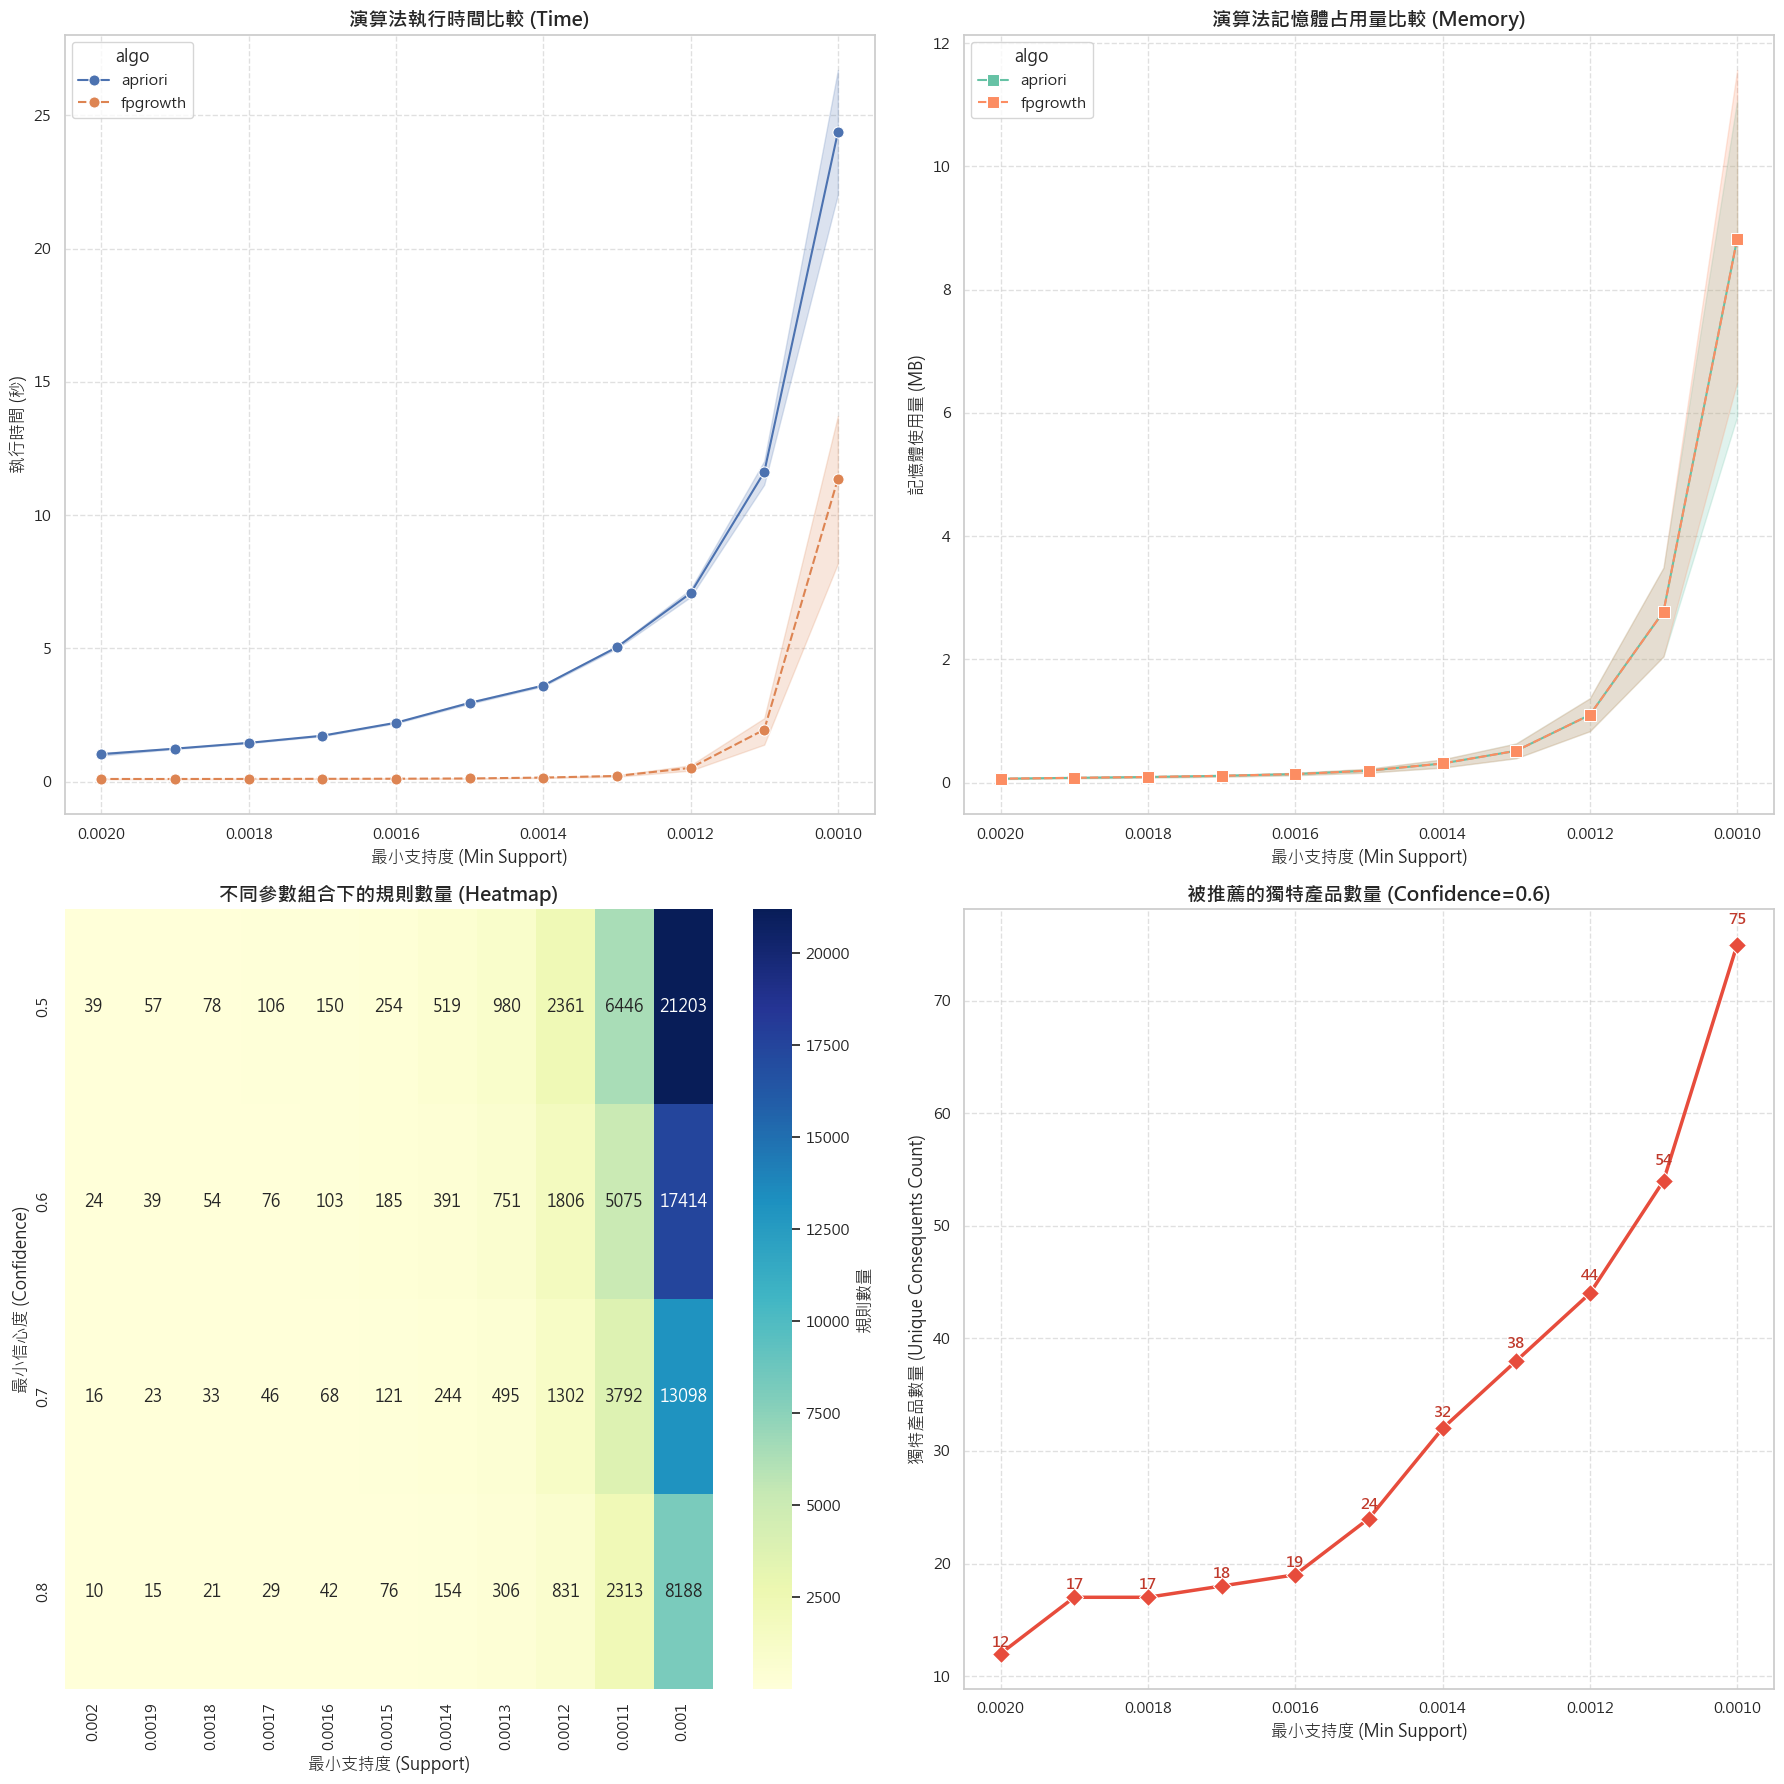

In [12]:
# 使用自動選擇的最佳信心度 (若無則預設 0.6)
target_conf = best_params['confidence'] if 'best_params' in locals() else 0.6
print(f"🔄 正在計算不同支持度下的推薦產品數量 (固定信心度: {target_conf})...")

unique_counts_list = []
# 取得測試過的所有 Support 值 (排序由大到小)
if 'df_results' in locals() and not df_results.empty:
    supports_to_test = sorted(df_results['support'].unique(), reverse=True)
else:
    # 若無實驗數據，使用預設範圍
    supports_to_test = [0.002, 0.0018, 0.0016, 0.0014, 0.0012, 0.001]

for supp in tqdm(supports_to_test, desc="Computing Metrics"):
    try:
        # 使用 fpgrowth 快速計算頻繁項目集
        fi = fpgrowth(df_encoded, min_support=supp, use_colnames=True)
        
        if not fi.empty:
            # 產生關聯規則
            rules = association_rules(fi, metric="confidence", min_threshold=target_conf)
            
            if not rules.empty:
                # 計算後項 (Consequents) 中出現的不重複商品數
                # rules['consequents'] 是 frozenset 的集合，將其攤平並取聯集
                unique_items = set().union(*rules['consequents'])
                count = len(unique_items)
            else:
                count = 0
        else:
            count = 0
            
        unique_counts_list.append({'support': supp, 'unique_consequents': count})
        
    except Exception as e:
        print(f"⚠️ Error at support {supp}: {e}")
        unique_counts_list.append({'support': supp, 'unique_consequents': 0})

# 轉為 DataFrame 方便繪圖
df_unique = pd.DataFrame(unique_counts_list)

fig, axes = plt.subplots(2, 2, figsize=(18, 18))
plt.subplots_adjust(hspace=0.3, wspace=0.2) # 調整子圖間距

# --- 圖表 1: 演算法執行時間比較 (Time) ---
if 'df_results' in locals() and not df_results.empty:
    sns.lineplot(ax=axes[0, 0], data=df_results, x='support', y='time', hue='algo', 
                 marker='o', style='algo', markersize=8)
    axes[0, 0].set_title('演算法執行時間比較 (Time)', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('最小支持度 (Min Support)', fontsize=12)
    axes[0, 0].set_ylabel('執行時間 (秒)', fontsize=12)
    axes[0, 0].invert_xaxis() # X軸由大至小
    axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# --- 圖表 2: 演算法記憶體占用量比較 (Memory) ---
if 'df_results' in locals() and not df_results.empty:
    sns.lineplot(ax=axes[0, 1], data=df_results, x='support', y='memory_mb', hue='algo', 
                 marker='s', style='algo', markersize=8, palette='Set2')
    axes[0, 1].set_title('演算法記憶體占用量比較 (Memory)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('最小支持度 (Min Support)', fontsize=12)
    axes[0, 1].set_ylabel('記憶體使用量 (MB)', fontsize=12)
    axes[0, 1].invert_xaxis()
    axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# --- 圖表 3: 參數對規則數量的影響 (Heatmap) ---
if 'df_results' in locals() and not df_results.empty:
    # 取 FP-Growth 的結果來畫熱力圖
    heatmap_data = df_results[df_results['algo'] == 'fpgrowth'].pivot(
        index='confidence', columns='support', values='rules_count'
    )
    sns.heatmap(ax=axes[1, 0], data=heatmap_data, annot=True, fmt='d', cmap='YlGnBu', 
                cbar_kws={'label': '規則數量'})
    axes[1, 0].set_title('不同參數組合下的規則數量 (Heatmap)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('最小支持度 (Support)', fontsize=12)
    axes[1, 0].set_ylabel('最小信心度 (Confidence)', fontsize=12)
    axes[1, 0].invert_xaxis()

# --- [新增] 圖表 4: 獨特推薦產品數量 vs 支持度 ---
if not df_unique.empty:
    sns.lineplot(ax=axes[1, 1], data=df_unique, x='support', y='unique_consequents', 
                 marker='D', color='#e74c3c', markersize=9, linewidth=2.5)
    
    # 設定標題與軸標籤
    axes[1, 1].set_title(f'被推薦的獨特產品數量 (Confidence={target_conf})', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('最小支持度 (Min Support)', fontsize=12)
    axes[1, 1].set_ylabel('獨特產品數量 (Unique Consequents Count)', fontsize=12)
    
    # X軸設定：數值由大至小
    axes[1, 1].invert_xaxis() 
    
    # 加上格線與數據標籤
    axes[1, 1].grid(True, linestyle='--', alpha=0.6)
    for x, y in zip(df_unique['support'], df_unique['unique_consequents']):
        axes[1, 1].text(x, y + (y*0.02), f'{y}', ha='center', va='bottom', fontsize=11, fontweight='bold', color='#c0392b')
else:
    axes[1, 1].text(0.5, 0.5, '無數據可顯示', ha='center', va='center')

plt.tight_layout()
plt.show()

讀取與展示規則

In [9]:
print("\n" + "="*60)
print("📂 讀取已儲存的關聯規則")
print("="*60)

# 讀取規則（會自動顯示統計摘要）
target_rules = load_rules("association_rules.pkl", display=True)

# 如果成功讀取，立即顯示規則表格
if target_rules is not None and not target_rules.empty:
    # 顯示前 10 條規則（依 Lift 排序）
    display_rules_table(target_rules, top_k=10, metric='lift')
    
    # 可選：顯示其他排序方式
    print("\n💡 提示：您也可以查看其他排序方式的規則")
    print("   例如：display_rules_table(target_rules, top_k=10, metric='confidence')")
else:
    print("\n⚠️ 無法讀取規則，請確認：")
    print("   1. 是否已執行「建立最終模型」步驟")
    print("   2. 檔案 association_rules.pkl 是否存在")


📂 讀取已儲存的關聯規則
✅ 成功讀取規則檔: association_rules.pkl
   📊 規則數量: 1806 條
   💾 檔案大小: 198.06 KB

📈 規則統計摘要
   Support 範圍:    0.0012 ~ 0.0029
   Confidence 範圍: 0.6000 ~ 1.0000
   Lift 範圍:       39.58 ~ 669.78
   平均 Lift:       263.69

📊 前 10 條關聯規則（依 LIFT 排序）



,購買商品 (前項),推薦商品 (後項),支持度,信心度,提升度
634,"PBSS4240T,215, PDZ13B,115","PBSS5240T,215, PDZ16B,115",0.0012,0.923,669.78
633,"PBSS5240T,215, PDZ16B,115","PBSS4240T,215, PDZ13B,115",0.0012,0.889,669.78
621,"PBSS4240T,215, PDZ15B,115","PBSS5240T,215, PDZ16B,115",0.0012,0.857,621.94
620,"PBSS5240T,215, PDZ16B,115","PBSS4240T,215, PDZ15B,115",0.0012,0.889,621.94
1284,"PBSS5240T,215, PDZ13B,115","2N7002BK,215, PDZ12B,115",0.0012,0.800,602.80
1775,"PDZ20B,115, BAS316,115","PDZ4.7B,115, PMBT4401,215",0.0012,0.800,602.80
1686,"PMBT4403/DLTR, BAS316,115","PDZ6.2B,115, PMBT4401,215",0.0012,0.800,602.80
1285,"2N7002BK,215, PDZ12B,115","PBSS5240T,215, PDZ13B,115",0.0012,0.923,602.80
1778,"PDZ4.7B,115, PMBT4401,215","PDZ20B,115, BAS316,115",0.0012,0.923,602.80
1685,"PDZ6.2B,115, PMBT4401,215","PMBT4403/DLTR, BAS316,115",0.0012,0.923,602.80





💡 提示：您也可以查看其他排序方式的規則
   例如：display_rules_table(target_rules, top_k=10, metric='confidence')


推薦系統展示

In [ ]:
def recommend_products(input_basket, rules_df, top_k=5, min_confidence=0.5):
    
    if rules_df is None or rules_df.empty:
        return []
    
    current_basket_set = frozenset(input_basket)
    recommendations = {}  # {商品: (信心度, lift)}
    
    for _, row in rules_df.iterrows():
        # 檢查購物籃是否包含規則的前項
        if row['antecedents'].issubset(current_basket_set):
            conf = row['confidence']
            lift = row['lift']
            
            # 信心度篩選
            if conf < min_confidence:
                continue
            
            for item in row['consequents']:
                if item not in current_basket_set:
                    # 綜合評分：信心度 * 0.7 + 標準化lift * 0.3
                    score = conf * 0.7 + min(lift / 3, 1.0) * 0.3
                    
                    if item in recommendations:
                        # 保留最高分
                        if score > recommendations[item][0]:
                            recommendations[item] = (score, conf, lift)
                    else:
                        recommendations[item] = (score, conf, lift)
    
    # 排序並返回
    sorted_recs = sorted(
        recommendations.items(),
        key=lambda x: x[1][0],  # 依綜合評分排序
        reverse=True
    )
    
    return [(item, score, conf, lift) for item, (score, conf, lift) in sorted_recs[:top_k]]


def interactive_recommendation_system(rules_df):

    if rules_df is None or rules_df.empty:
        print("⚠️ 無法啟動推薦系統：規則集為空")
        return
    
    print("\n" + "="*60)
    print("🛒 互動式產品推薦系統")
    print("="*60)
    print("📝 使用說明：")
    print("   • 請輸入已購買的產品名稱，多項產品請用「逗號」分隔")
    print("   • 輸入 'exit' 或 'q' 結束測試")
    print("   • 輸入 'sample' 查看範例商品")
    print("="*60)
    
    # 提供範例
    sample_items = list(rules_df.iloc[0]['antecedents'])
    print(f"\n💡 測試提示 - 範例商品組合:")
    print(f"   {', '.join(sample_items[:3])}")
    
    while True:
        try:
            print("\n" + "-"*60)
            user_input = input("🛍️  請輸入購物籃內容: ").strip()
            
            if user_input.lower() in ['exit', 'q', 'quit']:
                print("\n👋 感謝使用，系統已關閉。")
                break
            
            if user_input.lower() == 'sample':
                # 顯示更多範例
                print("\n📦 範例商品列表（取自前 5 條規則）:")
                for i, row in rules_df.head(5).iterrows():
                    items = list(row['antecedents'])
                    print(f"   {i+1}. {', '.join(items[:3])}")
                continue
            
            if not user_input:
                print("⚠️  輸入不能為空，請重新輸入")
                continue
            
            # 處理輸入（支援全形和半形逗號）
            basket = [item.strip() for item in user_input.replace(',', ',').split(',') if item.strip()]
            
            print(f"\n📥 您的購物籃: {basket}")
            
            # 執行推薦
            recs = recommend_products(basket, rules_df, top_k=5, min_confidence=0.5)
            
            if recs:
                print(f"\n✨ 為您推薦以下商品:\n")
                print(f"{'排名':<6} {'推薦商品':<40} {'信心度':<10} {'提升度':<10}")
                print("-"*70)
                
                for idx, (item, score, conf, lift) in enumerate(recs, 1):
                    # 截斷過長的商品名稱
                    display_name = item[:37] + "..." if len(item) > 40 else item
                    print(f"{idx:<6} {display_name:<40} {conf:<10.3f} {lift:<10.2f}")
                
                print(f"\n💡 推薦理由：這些商品與您選購的商品具有強關聯性")
            else:
                print("\n🚫 暫無推薦商品")
                print("   可能原因：")
                print("   • 該組合未滿足信心度門檻（預設 0.5）")
                print("   • 無相關規則匹配")
                print("   • 建議嘗試其他商品組合")
            
        except KeyboardInterrupt:
            print("\n\n👋 強制結束。")
            break
        except Exception as e:
            print(f"\n❌ 發生錯誤: {e}")
            print("   請重新輸入或輸入 'exit' 離開")


# 啟動推薦系統
print("\n" + "="*60)
print("🎯 啟動推薦系統測試")
print("="*60)

if target_rules is not None and not target_rules.empty:
    interactive_recommendation_system(target_rules)
else:
    print("⚠️ 無法啟動推薦系統，請先確保規則已正確載入")
    print("   建議步驟：")
    print("   1. 執行「建立最終模型」區塊")
    print("   2. 重新執行「讀取規則」區塊")


🎯 啟動推薦系統測試

🛒 互動式產品推薦系統
📝 使用說明：
   • 請輸入已購買的產品名稱，多項產品請用「逗號」分隔
   • 輸入 'exit' 或 'q' 結束測試
   • 輸入 'sample' 查看範例商品

💡 測試提示 - 範例商品組合:
   WD1003FZEX

------------------------------------------------------------


🛍️  請輸入購物籃內容:  PBSS4240T,215, PDZ13B,115



📥 您的購物籃: ['PBSS4240T', '215', 'PDZ13B', '115']

🚫 暫無推薦商品
   可能原因：
   • 該組合未滿足信心度門檻（預設 0.5）
   • 無相關規則匹配
   • 建議嘗試其他商品組合

------------------------------------------------------------


🛍️  請輸入購物籃內容:  'PBSS4240T', '215', 'PDZ13B', '115'



📥 您的購物籃: ["'PBSS4240T'", "'215'", "'PDZ13B'", "'115'"]

🚫 暫無推薦商品
   可能原因：
   • 該組合未滿足信心度門檻（預設 0.5）
   • 無相關規則匹配
   • 建議嘗試其他商品組合

------------------------------------------------------------


🛍️  請輸入購物籃內容:  WD1003FZEX



📥 您的購物籃: ['WD1003FZEX']

✨ 為您推薦以下商品:

排名     推薦商品                                     信心度        提升度       
----------------------------------------------------------------------
1      WD30EZRZ                                 0.667      189.29    
2      WD5000LPLX                               0.650      219.55    

💡 推薦理由：這些商品與您選購的商品具有強關聯性

------------------------------------------------------------
